In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os

from time import time

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch
torch.set_default_tensor_type(torch.DoubleTensor)

import gait
import utils

In [5]:
os.makedirs('./data/mnist', exist_ok=True)

mnist = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data/mnist', train=True, download=False,))
#letters = torch.utils.data.DataLoader(torchvision.datasets.EMNIST('./data/EMNIST', 'letters', train=True, download=True,))
#fashion = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST('./data/fashion', train=True, download=False))

In [6]:
img_size = 28

[Ygrid, Xgrid] = np.meshgrid(np.linspace(0, 1, img_size), np.linspace(0, 1, img_size))
Kmat = np.exp(-np.abs(Xgrid - Ygrid)**2/(0.05**2))
Kmat = torch.tensor(Kmat)

img_kernel = lambda x: torch.matmul(torch.matmul(Kmat, x), Kmat)

tform = torchvision.transforms.Compose(
                      [torchvision.transforms.ToPILImage(),
                       torchvision.transforms.RandomAffine(10, translate=(0., 0.), scale=(0.5, 1), shear=0, resample=False, fillcolor=0),
                       torchvision.transforms.ToTensor()
                      ])
#plt.matshow(Kmat)
data = mnist

### Show data samples

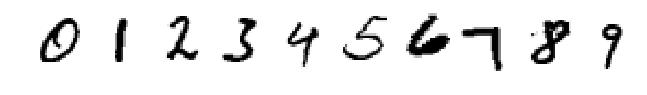

In [7]:
toshow = []
for digit in range(0, 10):
    ix = data.dataset.targets == digit
    D = data.dataset.data[ix].view(-1, 28, 28).float()
    toshow.append(D[np.random.choice(D.shape[0])])
    
plt.figure(figsize=(11, 2))
plt.imshow(torch.cat(toshow, dim=1).data.numpy(), cmap='gray_r')
plt.axis('off')
plt.show()

### Compute barycenters

In [9]:
barys = []

for digit in range(0, 10):
    start = time()
    ix = data.dataset.targets == digit
    D = data.dataset.data[ix].view(-1, 28, 28).float()
    
    # for EMNIST
    #D = data.dataset.train_data[ix].view(-1, 28, 28).transpose(-1, -2).float()
    
    logit_q = torch.nn.Parameter(0*torch.rand(1, img_size*img_size))
    temp = torch.nn.Parameter(torch.tensor(0.1))

    optimizer = torch.optim.Adam([logit_q, temp], lr=0.03, amsgrad=True)
    
    for i in range(500):

        optimizer.zero_grad()
        
        q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(1, img_size, img_size) 
        p = utils.sample_and_resize(D[0:-1, ...], img_size, 32)
        
        loss = gait.breg_sim_divergence(img_kernel, p, q).mean() #this is convex
        
        if i % 100 == 0:
            print("%d - %d : %.3e" % (digit, i, loss.item()))

        if False and i % 100 == 0:
            q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(img_size, img_size).data
            plt.figure(figsize=(1, 1))
            plt.imshow(q, cmap='gray_r');
            plt.show()

        loss.backward()
        optimizer.step()
    
    q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(img_size, img_size)
    barys.append(q.data)
    
    print('Class time: ', time()-start)

0 - 0 : 1.404e+00
0 - 100 : 5.290e-01
0 - 200 : 4.951e-01
0 - 300 : 5.135e-01
0 - 400 : 4.507e-01
Class time:  6.253126859664917
1 - 0 : 2.143e+00
1 - 100 : 5.374e-01
1 - 200 : 5.486e-01
1 - 300 : 5.100e-01
1 - 400 : 7.565e-01
Class time:  6.263250112533569
2 - 0 : 1.489e+00
2 - 100 : 5.569e-01
2 - 200 : 5.552e-01
2 - 300 : 6.365e-01
2 - 400 : 5.464e-01
Class time:  6.106867551803589
3 - 0 : 1.513e+00
3 - 100 : 5.855e-01
3 - 200 : 5.427e-01
3 - 300 : 4.787e-01
3 - 400 : 5.127e-01
Class time:  6.367943525314331
4 - 0 : 1.702e+00
4 - 100 : 5.804e-01
4 - 200 : 6.236e-01
4 - 300 : 6.343e-01
4 - 400 : 6.353e-01
Class time:  6.370590925216675
5 - 0 : 1.600e+00
5 - 100 : 5.988e-01
5 - 200 : 6.585e-01
5 - 300 : 7.309e-01
5 - 400 : 7.576e-01
Class time:  6.655850887298584
6 - 0 : 1.604e+00
6 - 100 : 5.395e-01
6 - 200 : 5.009e-01
6 - 300 : 6.186e-01
6 - 400 : 5.378e-01
Class time:  6.7001893520355225
7 - 0 : 1.788e+00
7 - 100 : 7.068e-01
7 - 200 : 6.484e-01
7 - 300 : 5.483e-01
7 - 400 : 6.800e-0

### Show computed barycenters

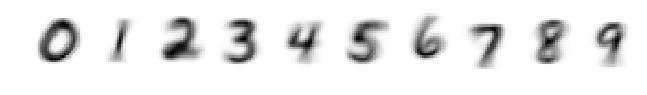

In [14]:
plt.figure(figsize=(1.1*len(barys), 2.5))
cat_barys = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in barys], dim=1)
plt.imshow(cat_barys**1.2, cmap='gray_r')
plt.axis('off')
#plt.savefig('mnist_gray_barys_breg', dpi=300)
plt.show()